In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv


# Importing Libraries

In [2]:
import time
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

# Load Data

In [3]:
train=pd.read_csv("../input/demand-forecasting-kernels-only/train.csv")
test=pd.read_csv("../input/demand-forecasting-kernels-only/test.csv")
sample=pd.read_csv("../input/demand-forecasting-kernels-only/sample_submission.csv")
df = pd.concat([train, test], sort=False)
df.date=pd.to_datetime(df.date)

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################", end="\n\n")
    print(dataframe.shape, end="\n\n")
    print("##################### Types #####################", end="\n\n")
    print(dataframe.dtypes, end="\n\n")
    print("##################### Head #####################", end="\n\n")
    print(dataframe.head(head), end="\n\n")
    print("##################### Tail #####################", end="\n\n")
    print(dataframe.tail(head), end="\n\n")
    print("##################### NA #####################", end="\n\n")
    print(dataframe.isnull().sum(), end="\n\n")
    print("##################### Quantiles #####################", end="\n\n")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T, end="\n\n")
    
    
def check_df_2(dataframe, head=5):
    print("##################### Shape #####################", end="\n\n")
    print(dataframe.shape, end="\n\n")
    print("##################### Types #####################", end="\n\n")
    print(dataframe.dtypes, end="\n\n")
    print("##################### Head #####################", end="\n\n")
    print(dataframe.head(head), end="\n\n")
    print("##################### Tail #####################", end="\n\n")
    print(dataframe.tail(head), end="\n\n")
    print("##################### NA #####################", end="\n\n")
    print(dataframe.isnull().sum(), end="\n\n")
    print("##################### Quantiles #####################", end="\n\n")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T, end="\n\n")
    print("##################### store-item-year-month #####################", end="\n\n")
    print(dataframe.groupby(["store", "item", "year", "month"]).agg({"sales": ["sum", "mean", "median", "std"]}),
          end="\n\n")
    print("##################### store-year-month #####################", end="\n\n")
    print(dataframe.groupby(["store", "year", "month"]).agg({"sales": ["sum", "mean", "median", "std"]}),
          end="\n\n")
    print("##################### item-year-month #####################", end="\n\n")
    print(dataframe.groupby(["item", "year", "month"]).agg({"sales": ["sum", "mean", "median", "std"]}), 
         end="\n\n")
    print("##################### year-month #####################", end="\n\n")
    print(dataframe.groupby(["year", "month"]).agg({"sales": ["sum", "mean", "median", "std"]}), end="\n\n")
    print("##################### year #####################", end="\n\n")
    print(dataframe.groupby(["year"]).agg({"sales": ["sum", "mean", "median", "std"]}), end="\n\n")
    print("##################### month #####################", end="\n\n")
    print(dataframe.groupby(["month"]).agg({"sales": ["sum", "mean", "median", "std"]}), end="\n\n")
    
    
def create_date_features(data):
    data['month'] = data.date.dt.month
    data['day_of_month'] = data.date.dt.day
    data['day_of_year'] = data.date.dt.dayofyear
    data['week_of_year'] = data.date.dt.weekofyear
    data['day_of_week'] = data.date.dt.dayofweek
    data['year'] = data.date.dt.year
    data["is_wknd"] = data.date.dt.weekday // 4
    data['is_month_start'] = data.date.dt.is_month_start.astype(int)
    data['is_month_end'] =data.date.dt.is_month_end.astype(int)
    return data


def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe


def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))


def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


In [5]:
check_df(df)

##################### Shape #####################

(958000, 5)

##################### Types #####################

date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object

##################### Head #####################

        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN

##################### Tail #####################

            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0

##################### NA #####################

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

########

# Feature Engineering

In [6]:
df = create_date_features(df)

In [7]:
check_df_2(df)

##################### Shape #####################

(958000, 14)

##################### Types #####################

date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int64
is_month_end               int64
dtype: object

##################### Head #####################

        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
0 2013-01-01      1     1   13.0 NaN      1             1            1             1            1  2013        0               1             0
1 2013-01-02      1     1   11.0 NaN      1             2            2 

# Lag/Shifted Features

In [8]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
lags = [91, 98, 105, 112, 119, 126, 182, 238, 364, 455, 546, 728]
df = lag_features(df, lags)

# Rolling Mean Features

In [9]:
windows = [121, 181, 365, 546]
df = roll_mean_features(df, windows )

# Exponentially Weighted Mean Features

In [10]:
alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 119, 126, 182, 238, 364, 455, 546, 728]
df = ewm_features(df, alphas, lags)

In [11]:
check_df(df)

##################### Shape #####################

(958000, 102)

##################### Types #####################

date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_238           float64
sales_ewm_alpha_05_lag_364           float64
sales_ewm_alpha_05_lag_455           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 102, dtype: object

##################### Head #####################

        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_238  sales_lag_364  sales_lag_455  sales_lag_546  sal

# One-Hot Encoding

In [12]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

# Converting sales to log(1+sales)

In [13]:
df['sales'] = np.log1p(df["sales"].values)

# Time-Based Validation Sets

In [14]:
train = df.loc[(df["date"] >= "2015-01-01") &(df["date"] < "2017-01-01"), :]
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((365500,), (365500, 173), (45000,), (45000, 173))

# LightGBM Model

In [15]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.01,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [16]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248587 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.215032	training's SMAPE: 21.7764	valid_1's l1: 0.216804	valid_1's SMAPE: 22.013
[200]	training's l1: 0.148663	training's SMAPE: 15.1766	valid_1's l1: 0.157183	valid_1's SMAPE: 16.0981
[300]	training's l1: 0.134583	training's SMAPE: 13.7661	valid_1's l1: 0.145533	valid_1's SMAPE: 14.9304
[400]	training's l1: 0.131074	training's SMAPE: 13.4151	valid_1's l1: 0.142393	valid_1's SMAPE: 14.6157
[500]	training's l1: 0.12983	training's SMAPE: 13.2907	valid_1's l1: 0.141332	valid_1's SMAPE: 14.5096
[600]	training's l1: 0.129125	training's SMAPE: 13.2199	valid_1's l1: 0.140595	valid_1's SMAPE: 14.4359
[700]	training's l1: 0.128583	training's SMAPE: 13.1653	valid_1's l1: 0.139999	valid_1's SMAPE: 14.376
[800]	training's l1: 0.128114	training's SMAPE: 

13.476169618077607

# Feature Importance

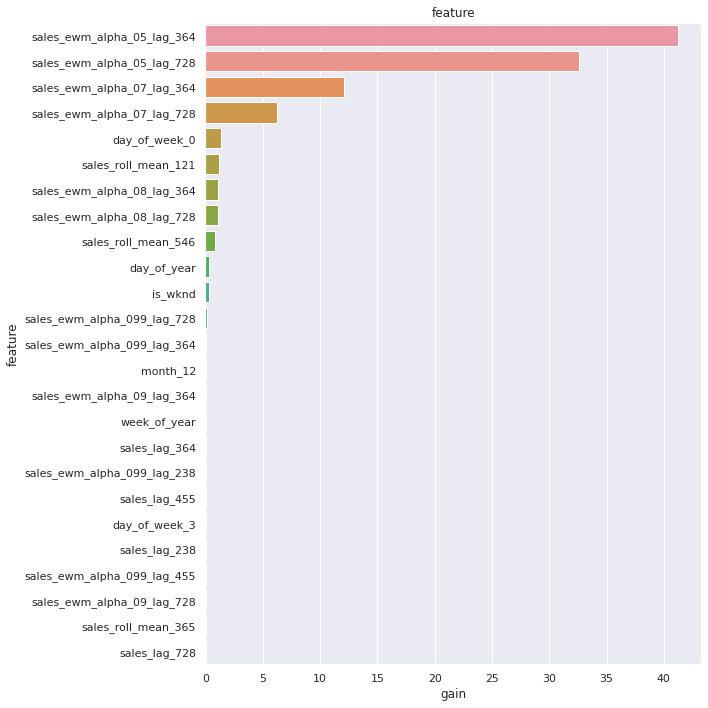

In [17]:
plot_lgb_importances(model, num=30, plot=True)

# Final Model

In [18]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}


# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

test_preds = model.predict(X_test, num_iteration=model.best_iteration)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.622656 seconds.
You can set `force_col_wise=true` to remove the overhead.


# Submission

In [19]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv('submission.csv', index=False)
submission_df.head(20)

,id,sales
0,0,12.021048
1,1,13.694523
2,2,14.165316
3,3,14.962911
4,4,16.778482
5,5,17.351811
6,6,18.956009
7,7,12.694049
8,8,14.569012
9,9,13.186311
